# Graph Building using networkx
A network analysis of the authorship networks in the top 5 economic journals from 1940 to 2020 replicating the methodology in “Economics: An Emerging Small World.” (Goyal, Van der Leij and Moraga-Gonzalez , 2006). Their paper examines the evolution of social distance using network analysis to show that it has become easier to maintain and form distant ties amongst economists because of technological developments in travel and communication, at least over the 1970 - 2020 period. 

Note that our metadata contains author name and publication data dating back to the first publication of each journal, these being American Economic Review (), Econometrica (), Journal of political economy(), Review of economic studies() and Quarterly Journal of Economics(). The earliest article occurs in 1884. Although I will only be examining the period 1940 to 2020, this notebook still builds all networks within the period 1881 to 2020 where each network is built with coauthor data of articles from every 10-year interval ie: 1881-1890, 1891-1900, 1901-1910 ... 2011-2020. 

### Notes:

Each author is a node and each link between two authors indicates they have coauthored at least one article in the top 5 economic journals. If A and B are linked, they have a distance of 1. If C is directly linked to B but not A, then A and C are said to have a distance of 2. All authors who are either directly or indirectly linked with each other are said to belong to the same component, the largest set of interconnected authors is called the giant component if it consitutes a large percentage of nodes and the other components are relatively small. A larger relative size of the giant component and a shorter average distance between economists in the giant component is evidence that the world is becoming smaller.

Definitions from Goyal et al.:

**Degree**: the number of coathors an author has in a network.

**Giant component**: Two persons belong to the same component if and only if there exists a path between them. A component is a giant component if the largest component constitutes a relatively large part of the population of economists and all other components are small.

**Distance**: the shortest path between two authors. The distance is infinity if the authors if a path does not exist between two authors.

**Clustering**: The clustering coefficient of a network is a measure of the overlap between the links of different authors. This ratio tells us the percentage of a′person’s coauthors who are coauthors of each other.

A network exhibits **small world** properties if: 
1. number of nodes is very large compared to the average number of coauthors. number of nodes>> average degree
2. the network is integrated; a giant component exists and covers a large share of the population
3. the average distance between nodes in the giant component is small: ie: the average distance is of order ln(n).
4. clustering is high such that the clustering coefficient is much larger than the average number of coauthors, CC >> average degree

Assumptions: affiliations resolved author name clashes in previous stage. 

Goyal, Sanjeev, Marco J. van der Leij, and José Luis Moraga‐González. “Economics: An Emerging Small World.” Journal of Political Economy 114, no. 2 (2006): 403–12. https://doi.org/10.1086/500990.

Disclaimer: copied and pasted most of this from Goyal et al..

In [2]:
import networkx as nx
import json
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
import numpy as np


In [3]:
base_path="/Users/sijiawu/Work/Thesis/Data/Affiliations/"

Load in author data. Assume this has already been fixed

In [ ]:
with open(base_path+"author_proc_reduced.json") as f: 
    data = f.read() 
proc_auths_all = json.loads(data) 

proc_auths=pd.read_pickle(base_path+"auth_proc_w_aff_flat.pkl")
j_data=pd.read_pickle(base_path.split('Aff')[0]+"Combined/022_merged_proc_scopus_inception_with_auth_split_2020_content_type_corrected.pkl")

In [5]:
proc_auths_all['https://doi.org/10.1093/qje/qjaa012']

{'authors': {'0': {'raw': 'Enke, Benjamin',
   'init': 'benjamin enke',
   'auth_suffix': [],
   'a1': 'benjamin enke',
   'a2': 'b. enke',
   'a3': 'b. enke',
   'affs': ['harvard university',
    'national bureau of economic research - nber']}},
 'year': 2020,
 'content_type': 'Article',
 'jid': 'qje'}

In [6]:
proc_auths_all['https://doi.org/10.1093/qje/qjaa012']

{'authors': {'0': {'raw': 'Enke, Benjamin',
   'init': 'benjamin enke',
   'auth_suffix': [],
   'a1': 'benjamin enke',
   'a2': 'b. enke',
   'a3': 'b. enke',
   'affs': ['harvard university',
    'national bureau of economic research - nber']}},
 'year': 2020,
 'content_type': 'Article',
 'jid': 'qje'}

Function for building a graph.

In [58]:
# function purpose: takes a start year, an end year and builds the network of authors between these years given the type of names "a1", "a2" etc.
# this function assumes the availability of a global proc_auths_all dictionary containing author names from the previous data cleaning stage. 
# start_year is the first year in which athurs enter the network
# end_year is the first year where authors are no longer part of this network
# al_class specifies the type of author name variation to use to build the network
# restrict excludes articles of the specified article types from the network.
def build_graph(start_year, end_year, al_class, restrict={"Article":0, "Review":0, "MISC":0, "Comment":0, "Reply":0, "Review2":0, "Discussion":0, "Rejoinder":0}):
    a=0
    b=[]
    c=[]
    content_type=[]
    years=2021
    G = nx.Graph()
    alias_all=[]
    for i in proc_auths_all.keys():
#         a=a+1
#         if a>1000:
#             break
        alias=[]
        entry=proc_auths_all[i]["authors"]
        years=min(years, proc_auths_all[i]["year"])
        # content_type.append(proc_auths_all[i]["content_type"])
        if restrict[proc_auths_all[i]["content_type"]]==1:
            continue
        if (proc_auths_all[i]["year"]<start_year) or (proc_auths_all[i]["year"]>=end_year):
            continue
        for j in range(len(entry.keys())):
            alias.append(entry[str(j)][al_class])
            alias_all.append(entry[str(j)][al_class])
        combinations = list(itertools.combinations(alias, 2))

        for l in alias:
            if G.has_node(l):
                n_count=len(G.nodes[l]["year"])
                G.nodes[l]["year"][n_count]=proc_auths_all[i]["year"]
                G.nodes[l]["weight"] = G.nodes[l]["weight"]+1
            else:
                G.add_node(l, year={0: proc_auths_all[i]["year"]})
                G.nodes[l]["weight"] = 1

        for k in combinations:
            if G.has_edge(*k):
                # we added this one before, just increase the weight by one
                G[k[0]][k[1]]['weight'] += 1
                e_count=len(G[k[0]][k[1]]['year'])
                G[k[0]][k[1]]['year'][e_count]=proc_auths_all[i]["year"]
            else:
                # new edge. add with weight=1
                G.add_edge(*k, weight=1, year={0:proc_auths_all[i]["year"]})
#     G=nx.convert_node_labels_to_integers(G, first_label=0, ordering='sorted', label_attribute="auth_name")
    # print(pd.DataFrame(content_type).value_counts())
    return [G, alias_all, years, b]


A function for computing average shortest path and standard deviation of shortest path within a connected component

In [59]:
# pairs: a list of tuple pairs
# pairs_dict: dictionary where tuple pairs resolve to a int or float
def pop_stats(pairs, pair_dict):
    sp=0
    ss=0
    x=[]
    n=len(pairs)
    print(n)
    if n<=1:
        return [None, None, x]
    for i in pairs:
        sp+=pair_dict[i[0]][i[1]]
        x.append(pair_dict[i[0]][i[1]])
        ss+=(pair_dict[i[0]][i[1]]**2)
    x_bar=sp/n
    s_squared=(ss-n*(x_bar**2))/(n-1)
    return [x_bar, s_squared**0.5, x]

Using the function above and network x, this function compiles the statistics for a network.

In [60]:
# G is a graph
def calc_network_stats(G):
    rd=3
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    # gcc_count=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
    G0 = G.subgraph(Gcc[0])
    G1 = G.subgraph(Gcc[1])
    G2 = G.subgraph(Gcc[2])
    
    degree_sequence = np.array(sorted((d for n, d in G.degree()), reverse=True))
    # print(np.array(degree_sequence))
    avg_deg=sum(degree_sequence)/G.number_of_nodes()
    deg_std=math.sqrt(sum((degree_sequence-avg_deg)**2)/(G.number_of_nodes()-1))
    isol=sum(degree_sequence==0)
    print("calculating shortest path stats")
    stime=time.time()
    
    p = dict(nx.shortest_path_length(G0))
    combinations = list(itertools.combinations(list(G0), 2))
    sp_stats=pop_stats(combinations, p)
    # plt.hist(sp_stats[2])
    # plt.show()
    print('creating random refs')
    
    K=nx.random_reference(G, niter=2)
    degree_sequence_=np.array(sorted((d for n, d in K.degree()), reverse=True))
    avg_deg_=sum(degree_sequence_)/K.number_of_nodes()
    deg_std_=math.sqrt(sum((degree_sequence_-avg_deg_)**2)/(K.number_of_nodes()-1))

    K2=nx.erdos_renyi_graph(G.number_of_nodes(), avg_deg/G.number_of_nodes())
    degree_sequence_2=np.array(sorted((d for n, d in K2.degree()), reverse=True))
    avg_deg_2=sum(degree_sequence_2)/K2.number_of_nodes()
    deg_std_2=math.sqrt(sum((degree_sequence_2-avg_deg_2)**2)/(K2.number_of_nodes()-1))



    p1 = dict(nx.shortest_path_length(G1))
    combinations = list(itertools.combinations(list(G1), 2))
    sp_stats1=pop_stats(combinations, p1)

    
    p2 = dict(nx.shortest_path_length(G2))
    combinations = list(itertools.combinations(list(G2), 2))
    sp_stats2=pop_stats(combinations, p2)

    
    etime=time.time()    
    print("path stat calc complete " +str(etime-stime))
    
    return {
        "Number of nodes": G.number_of_nodes(),
        "Number of edges":G.number_of_edges(),
        "Number of CC": nx.number_connected_components(G),
        "LCC": len(G0),
        "LCC %": round(len(G0)*100/G.number_of_nodes(), rd),
        "2nd LCC": len(G1),
        "2nd LCC %": round(len(G1)*100/G.number_of_nodes(), rd),
        "3rd LCC": len(G2),
        "3rd LCC %": round(len(G2)*100/G.number_of_nodes(), rd),
        "AVG clustering": round(nx.average_clustering(G), max(rd, 5)),
        "AVG clustering rnd": round(nx.average_clustering(K), max(rd, 5)),
        "AVG clustering ER": round(nx.average_clustering(K2), max(rd, 5)),
        "AVG clustering weighted":nx.average_clustering(G, weight='weight'),
        "AVG clustering deg>1":nx.average_clustering(G, nodes=[n for n in G if G.degree(n) > 1]),
        "AVG clustering rnd deg>1": round(nx.average_clustering(K, nodes=[n for n in K if K.degree(n) > 1]), max(rd, 5)),
        "AVG clustering ER deg>1": round(nx.average_clustering(K2, nodes=[n for n in K2 if K2.degree(n) > 1]), max(rd, 5)),
        "AVG clustering weighted deg>1 ":nx.average_clustering(G, weight='weight',nodes=[n for n in G if G.degree(n) > 1]),
        "transitivity":round(nx.transitivity(K), max(rd, 5)),
        "centers of LCC":list(nx.center(G0)),
        "AVG degree": round(avg_deg, max(rd,5)),
        "degree std": round(deg_std, max(rd,5)),
        "degree std rnd": round(deg_std_, max(rd,5)),
        "degree std ER": round(deg_std_2, max(rd,5)),
        "isolated authors": isol,
        "isolated authors %":round(isol*100/G.number_of_nodes(), rd),
        "LCC avg shortest path": sp_stats[0] if sp_stats[0] is None else round(sp_stats[0], max(rd,5)),
        "LCC std shortest path": sp_stats[1] if sp_stats[1] is None else round(sp_stats[1], max(rd,5)), 
        "2nd LCC avg shortest path": sp_stats1[0] if sp_stats1[0] is None else round(sp_stats1[0], max(rd,5)),
        "2nd LCC std shortest path": sp_stats1[1] if sp_stats1[1] is None else round(sp_stats1[1], max(rd,5)),
        "3rd LCC avg shortest path": sp_stats2[0] if sp_stats2[0] is None else round(sp_stats2[0], max(rd,5)),
        "3rd LCC std shortest path": sp_stats2[1] if sp_stats2[1] is None else round(sp_stats2[1], max(rd,5))
    }


In [61]:
j_data.content_type.unique()

array(['Article', 'MISC', 'Comment', 'Reply', 'Errata', 'Rejoinder',
       'Discussion', 'Review', 'Review2'], dtype=object)

In [ ]:
# output=build_graph(1800, 2021, "a1", {"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":0, "Rejoinder":0})
output=build_graph(1940, 2021, "a1", {"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":1, "Rejoinder":0,"Errata":0})
L=output[0]
nx.write_gexf(L, "authnetwork_1940_2021_a1.gexf")

Gcc = sorted(nx.connected_components(L), key=len, reverse=True)
L0=L.subgraph(Gcc[0])
L.number_of_nodes()
calc_network_stats(L)
pd.DataFrame(calc_network_stats(L)).transpose().to_csv("full_net_1940_2020_a1.csv")

calculating shortest path stats
31780378
creating random refs


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1128b1b50>>
Traceback (most recent call last):
  File "/Users/sijiawu/Work/80YearsEconomicResearch/venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Testing the functions with the full set, ie: all authors of all time.

Build each 10-year network of authors from 1881 to 2021.

network for period: 1940 to 1950
calculating shortest path stats
1225


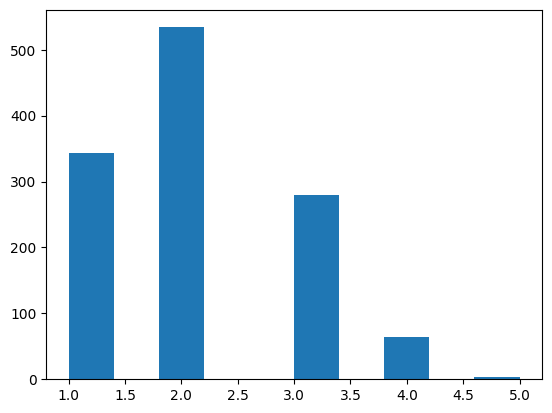

210
171
path stat calc complete 0.1264641284942627
network for period: 1950 to 1960
calculating shortest path stats
253


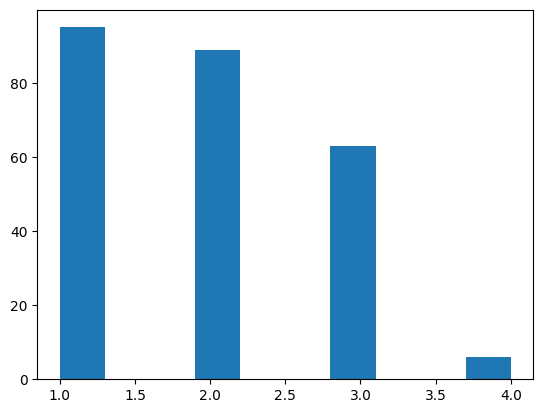

66
15
path stat calc complete 0.03981900215148926
network for period: 1960 to 1970
calculating shortest path stats
1596


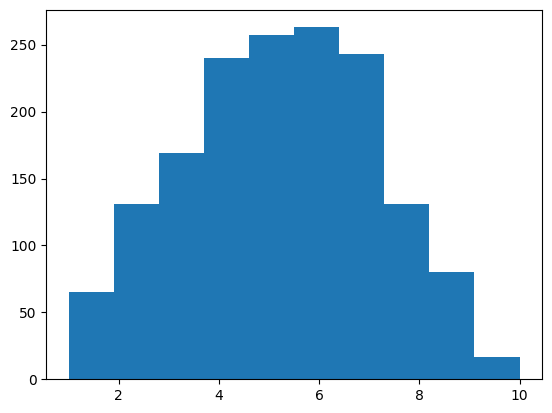

120
66
path stat calc complete 0.04081392288208008
network for period: 1970 to 1980
calculating shortest path stats
15931


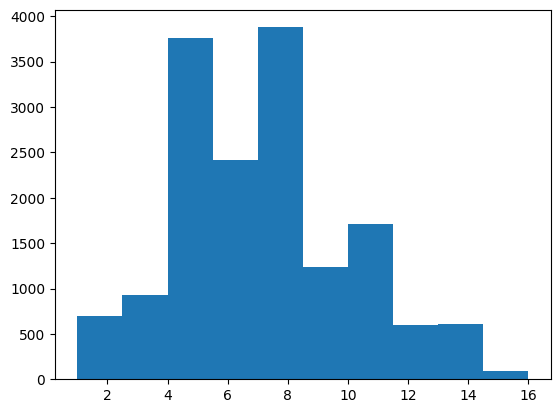

231
136
path stat calc complete 0.11638689041137695
network for period: 1980 to 1990
calculating shortest path stats
169071


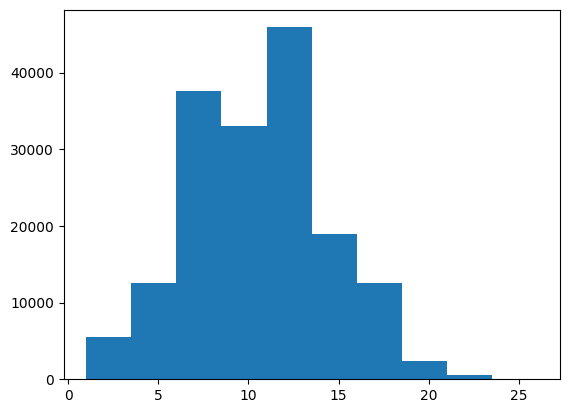

325
120
path stat calc complete 0.7654547691345215
network for period: 1990 to 2000
calculating shortest path stats
380628


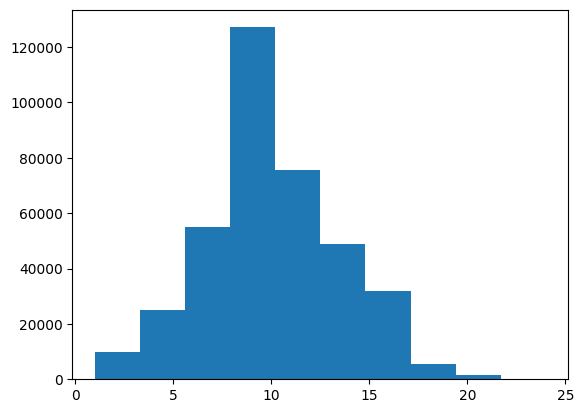

496
153
path stat calc complete 1.7200891971588135
network for period: 2000 to 2010
calculating shortest path stats
1304920


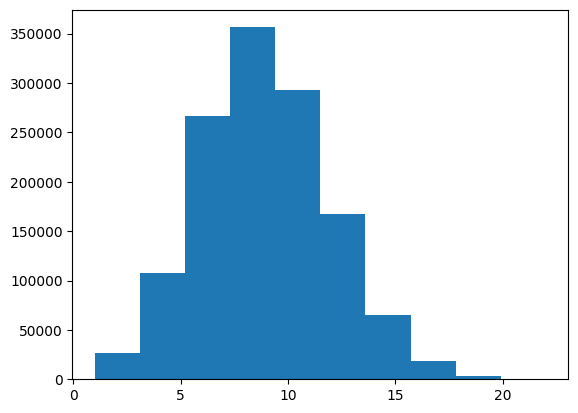

78
66
path stat calc complete 5.919464111328125
network for period: 2010 to 2020
calculating shortest path stats
3746953


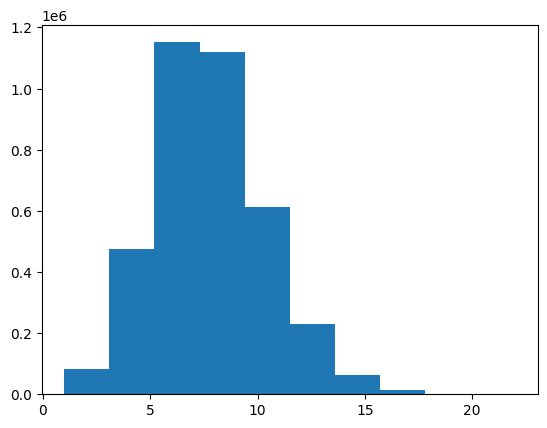

378
153
path stat calc complete 19.670485734939575


In [ ]:
networks={}
j=0
data=[]
for i in range(1940,2021,10):
    if (i+10)>2021:
        break
    print("network for period: "+str(i)+ " to "+ str(i+10))
    content_restrict={"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":1, "Rejoinder":0, "Errata":0}
    output=build_graph(i, i+10, "a1", content_restrict)
    networks[j]={"graph":output[0], "start":i, "end": i+10}
    op=calc_network_stats(output[0])
    op["start"]=i
    op['end']=i+10
    data.append(op)
    nx.write_gexf(output[0], "network_r_"+str(i)+"_"+str(i+10)+".gexf")



In [ ]:
df=pd.DataFrame(data)
df.to_excel("rolling_10Y_network_summary.xlsx", index=False)    
df.transpose().to_excel("rolling_10Y_network_summary_trans.xlsx")    
df.transpose().to_csv("rolling_10Y_network_summary_trans.csv")    

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)



In [ ]:
# contractions=pd.DataFrame(proc_auths[proc_auths['a1'].str[0:2].str.contains('\.')].value_counts(["year","journal"]))


network for period: 1940 to 1960
calculating shortest path stats
2628


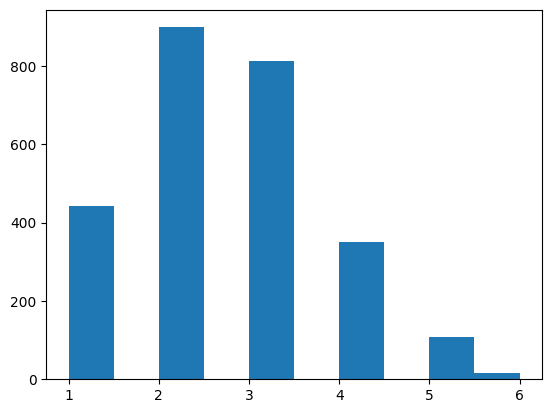

210
190
path stat calc complete 0.05791783332824707
network for period: 1960 to 1980
calculating shortest path stats
49141


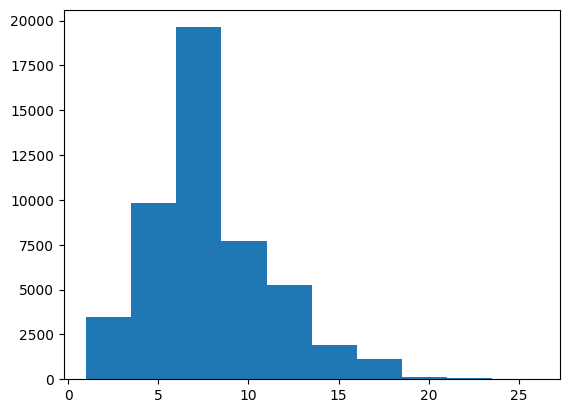

861
496
path stat calc complete 0.24787306785583496
network for period: 1980 to 2000
calculating shortest path stats
1902225


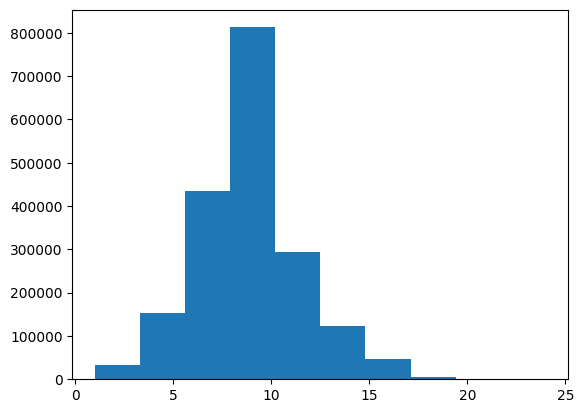

210
66
path stat calc complete 8.202086925506592
network for period: 2000 to 2020
calculating shortest path stats
10818226


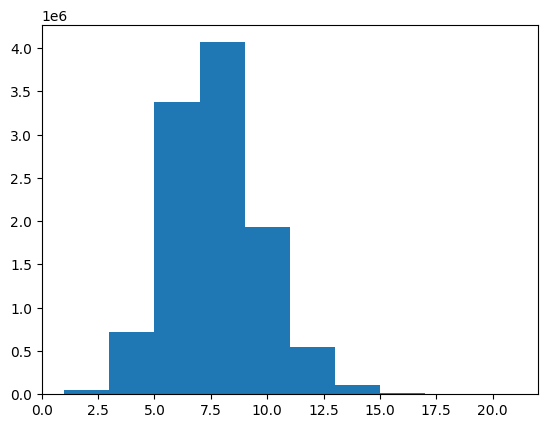

153
91
path stat calc complete 51.41543889045715


In [ ]:
networks_20={}
j=0
data_20=[]
for i in range(1940,2021,20):
    if (i+20)>2021:
        break
    print("network for period: "+str(i)+ " to "+ str(i+20))
    content_restrict={"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":1, "Rejoinder":0, "Errata":0}
    output=build_graph(i, i+20, "a1", content_restrict)
    networks_20[j]={"graph":output[0], "start":i, "end": i+20}
    op=calc_network_stats(output[0])
    op["start"]=i
    op['end']=i+20
    data_20.append(op)
    nx.write_gexf(output[0], "network_r_"+str(i)+"_"+str(i+20)+".gexf")



In [ ]:
df_20=pd.DataFrame(data_20)
df_20.to_excel("rolling_20Y_network_summary.xlsx", index=False)    
df_20.transpose().to_excel("rolling_20Y_network_summary_trans.xlsx")    
df_20.transpose().to_csv("rolling_20Y_network_summary_trans.csv")    

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
df_20

,Number of nodes,Number of edges,Number of CC,LCC,LCC %,2nd LCC,2nd LCC %,3rd LCC,3rd LCC %,AVG clustering,AVG clustering rnd,AVG cluster weighted,AVG cluster deg>1,AVG cluster deg>1 rnd,AVG cluster deg>1 weighted,transitivity,centers of LCC,AVG degree,degree std,isolated authors,isolated authors %,LCC avg shortest path,LCC std shortest path,2nd LCC avg shortest path,2nd LCC std shortest path,3rd LCC avg shortest path,3rd LCC std shortest path,start,end
0,2271,897,1891,73,3.214,21,0.925,20,0.881,0.07279,0.07279,0.016116,0.747955,0.74796,0.165605,0.84618,"[donald h. wallace, e. a. goldenweiser]",0.78996,2.69498,1718,75.649,2.55518,1.08086,2.18571,0.97273,1.83158,0.83764,1940,1960
1,4721,1951,3035,314,6.651,42,0.890,32,0.678,0.08821,0.08821,0.009231,0.479227,0.47923,0.050150,0.29288,[yoram weiss],0.82652,1.18043,2342,49.608,7.63218,3.33831,5.48084,2.86822,4.54637,2.15507,1960,1980
2,5814,4683,2336,1951,33.557,21,0.361,12,0.206,0.20635,0.00007,0.018666,0.546076,0.00019,0.049396,0.00068,[jose a. scheinkman],1.61094,1.89188,1475,25.370,8.80365,2.71889,3.08095,1.37236,2.01515,0.73364,1980,2000
3,7433,10894,1297,4652,62.586,18,0.242,14,0.188,0.45238,0.00094,0.029622,0.673728,0.00140,0.044115,0.00131,"[mikhail golosov, aleh tsyvinski, costas meghir]",2.93125,3.22526,520,6.996,7.21383,2.03825,2.75817,1.07008,2.36264,1.04898,2000,2020


network for period: 1940 to 1960
calculating shortest path stats
2628


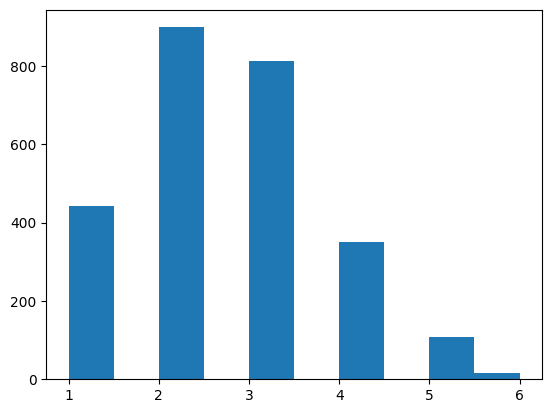

210
190
path stat calc complete 0.06454110145568848
network for period: 1950 to 1970
calculating shortest path stats
3655


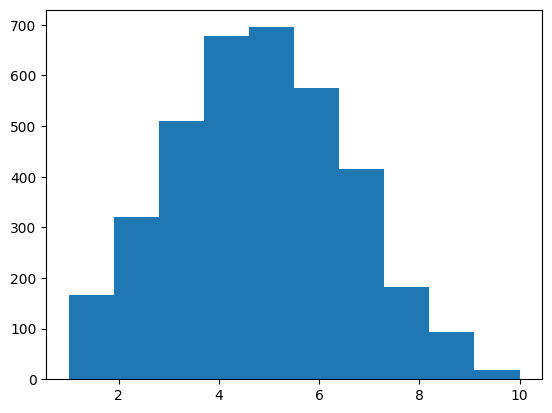

136
91
path stat calc complete 0.0536198616027832
network for period: 1960 to 1980
calculating shortest path stats
49141


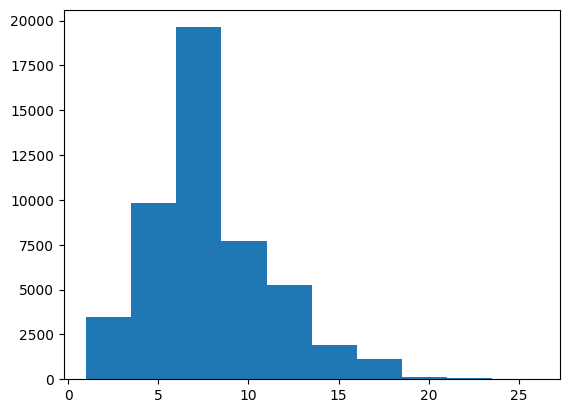

861
496
path stat calc complete 0.24556231498718262
network for period: 1970 to 1990
calculating shortest path stats
852165


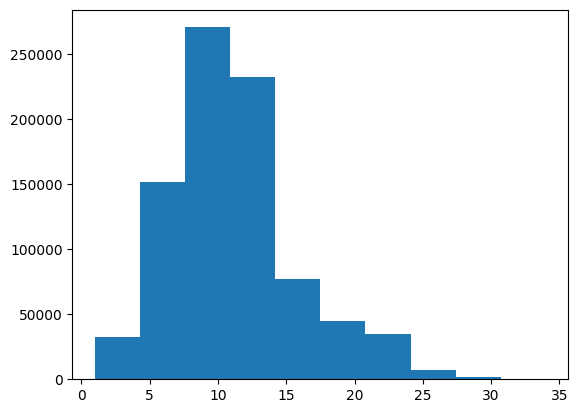

105
78
path stat calc complete 3.7046380043029785
network for period: 1980 to 2000
calculating shortest path stats
1902225


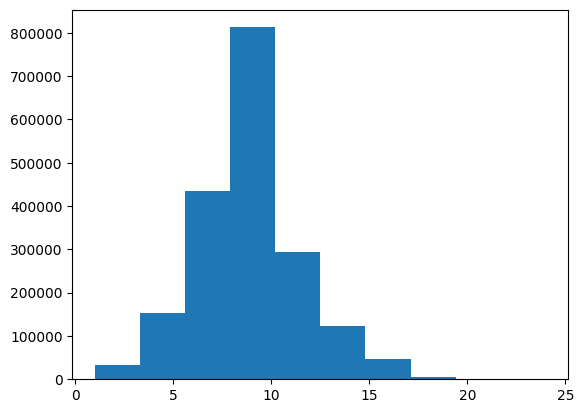

210
66
path stat calc complete 8.573143005371094
network for period: 1990 to 2010
calculating shortest path stats
4317391


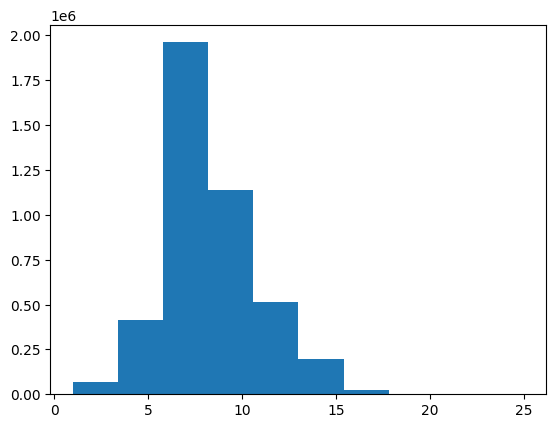

190
136
path stat calc complete 21.17205810546875
network for period: 2000 to 2020
calculating shortest path stats
10818226


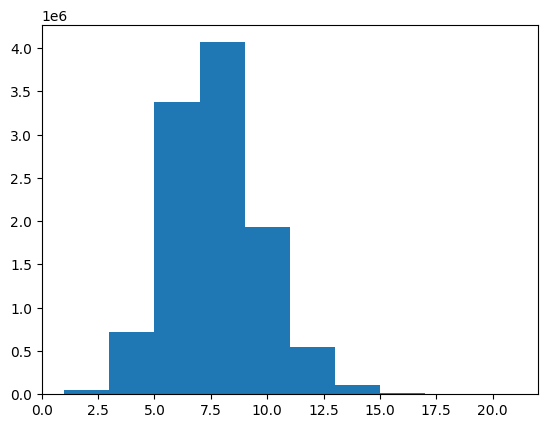

153
91
path stat calc complete 57.98493218421936


In [ ]:
networks_20_10={}
j=0
data_20_10=[]
for i in range(1940,2021,10):
    if (i+20)>2021:
        break
    print("network for period: "+str(i)+ " to "+ str(i+20))
    content_restrict={"Article":0, "Review":1, "MISC":1, "Comment":0, "Reply":0, "Review2":1, "Discussion":1, "Rejoinder":0, "Errata":0}
    output=build_graph(i, i+20, "a1", content_restrict)
    networks_20_10[j]={"graph":output[0], "start":i, "end": i+20}
    op=calc_network_stats(output[0])
    op["start"]=i
    op['end']=i+20
    data_20_10.append(op)
    nx.write_gexf(output[0], "network_r_"+str(i)+"_"+str(i+20)+"_10.gexf")



In [ ]:
df_20_10=pd.DataFrame(data_20_10)
df_20_10.to_excel("rolling_20Y_10Y_network_summary.xlsx", index=False)    
df_20_10.transpose().to_excel("rolling_20Y_10Y_network_summary_trans.xlsx")    
df_20_10.transpose().to_csv("rolling_20Y_10Y_network_summary_trans.csv")    

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
offenders=proc_auths[proc_auths['a1'].str[0:2].str.contains('\.')]
len(offenders['url'].unique())

3474

<Axes: xlabel='year', ylabel='count'>

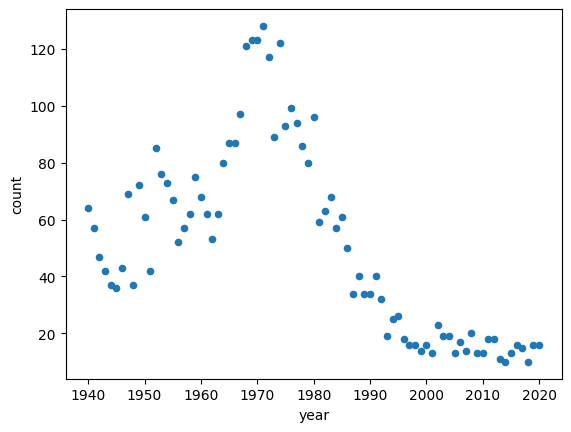

In [ ]:
contractions.plot(y="count", x="year", kind="scatter")

In [ ]:
proc_auths.shape

(46588, 14)

<Axes: title={'center': 'Comparing number of nodes with number of edges, number of isolated authors and number of nodes in the giant connected component'}, xlabel='Period', ylabel='Units'>

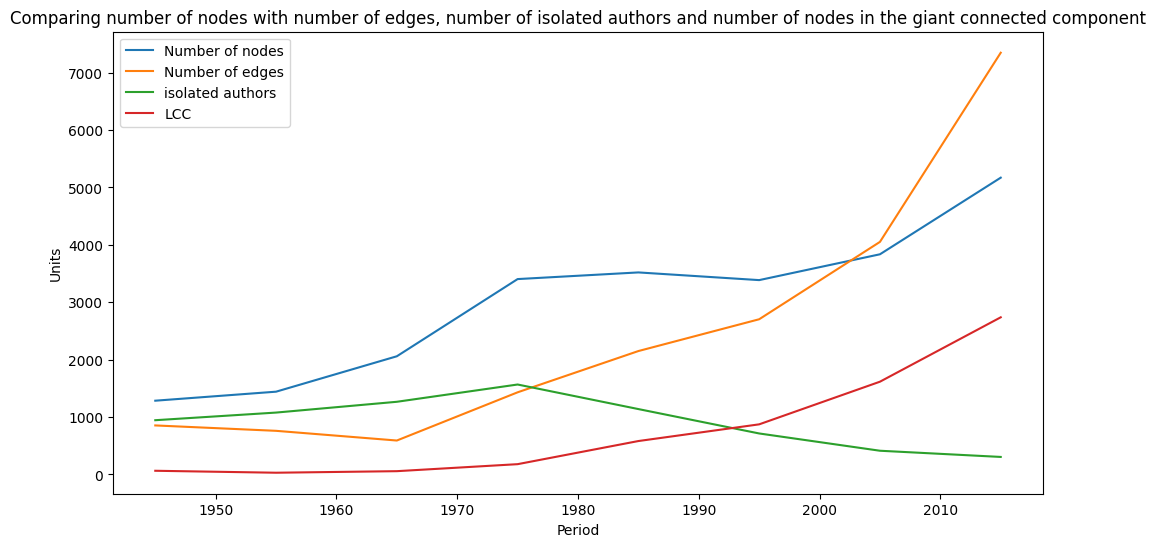

In [ ]:
# df[["Number of nodes","Number of edges","isolated authors"]].set_index(df["end"]).plot(x_label=)
# temp=(df["start"].astype(str)+"-"+df["end"].astype(str).str[-2:])
temp=(df["start"]+df["end"])/2

df[["Number of nodes","Number of edges","isolated authors","LCC"]].set_index(temp).plot(figsize = (12, 6), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Comparing number of nodes with number of edges, number of isolated authors and number of nodes in the giant connected component")

<Axes: title={'center': 'Comparing number of nodes with number of edges'}, xlabel='Period', ylabel='Units'>

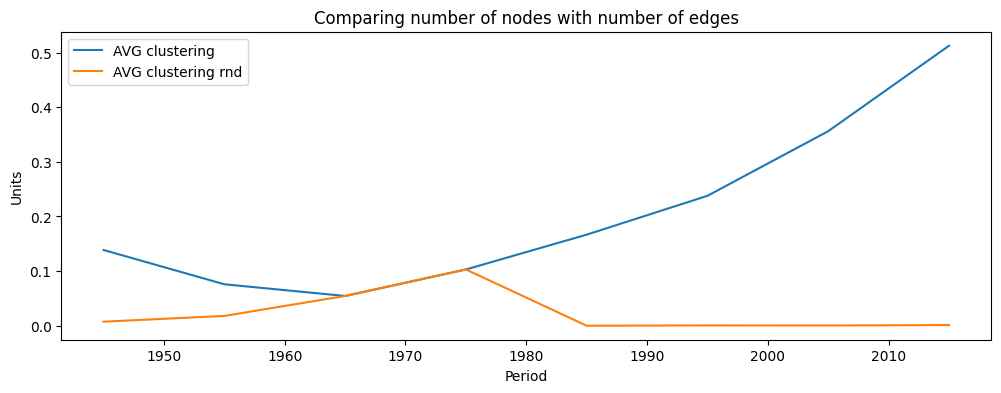

In [ ]:
df[["AVG clustering","AVG clustering rnd"]].set_index(temp).plot(figsize = (12, 4), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Comparing number of nodes with number of edges")

<Axes: title={'center': 'Considering distance in the Giant Component'}, xlabel='Period', ylabel='Units'>

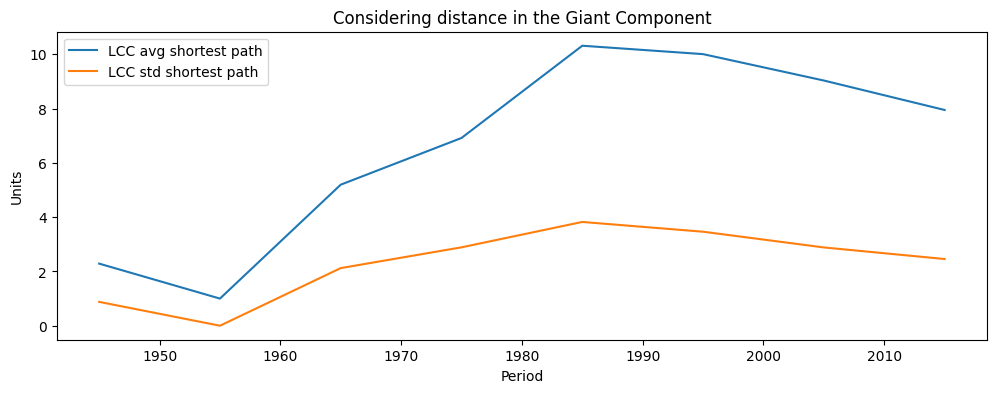

In [ ]:
df[["LCC avg shortest path", "LCC std shortest path"]].set_index(temp).plot(figsize = (12, 4), 
    # xticks=temp,
    xlabel="Period", 
    ylabel="Units", 
    title="Considering distance in the Giant Component")

1. number of nodes is very large compared to the average number of coauthors
2. the network is integrated; a giant component exists and covers a large share of the population
3. the average distance between nodes in the giant component is small: ie: the average distance is of order ln(n).
4. clustering is high such that the clustering coefficient is much larger than the average number of coauthors

In [ ]:
# the ugliest donut shaped graphs ever.
def plot_a_net(L, start, end):
    plt.figure()
    text="network graph of econ journal authors between "+str(start)+" and "+str(end)+" (exclusive). Nodes="+str(L.number_of_nodes())+". Edges="+str(L.number_of_edges())+'.'
    plt.title(text)
    nx.draw_spectral(L, with_labels=True, font_weight='light', node_size=5, font_size=5)
    plt.show()